In [1]:
# Nescessary imports

%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # supress tensorflow warnings


# import libraries
import sys
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import rotate

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

# set random seed
random.seed(42)

%load_ext autoreload

In [2]:
%autoreload 2
from classes.data_wraper import Dataset

In [3]:
# mount google drive if using google colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
if 'google.colab' in sys.modules:
    root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Colab Notebooks')
else:
    root_dir = os.getcwd()

if 'google.colab' in sys.modules:
    data_dir = os.path.join(root_dir, 'data')
else:
    data_dir = os.path.join(root_dir, 'data')

In [5]:
paths = {
    'FOVfiting2' : os.path.join(data_dir, 'mapsCeline_FOVfitting_2_pol-60.mat'),
    '3quadrants2' : os.path.join(data_dir, 'mapsCeline_3quadrants_2_pol-60.mat'),
    'FOVfiting3' : os.path.join(data_dir, 'mapsCeline_FOVfitting_3_pol-60.mat'),
    '3quadrants3' : os.path.join(data_dir, 'mapsCeline_3quadrants_3_pol-60.mat'),
    'FOVfiting4' : os.path.join(data_dir, 'mapsCeline_FOVfitting_4_pol-60.mat'),
    '3quadrants4' : os.path.join(data_dir, 'mapsCeline_3quadrants_4_pol-60.mat'),
    'FOVfiting5' : os.path.join(data_dir, 'mapsCeline_FOVfitting_5_pol-60.mat'),
    '3quadrants5' : os.path.join(data_dir, 'mapsCeline_3quadrants_5_pol-60.mat'),
    'FOVfiting6' : os.path.join(data_dir, 'mapsCeline_FOVfitting_6_pol-60.mat'),
    '3quadrants6' : os.path.join(data_dir, 'mapsCeline_3quadrants_6_pol-60.mat'),   
    'FOVfiting9' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9_pol-60.mat'),
    '3quadrants9' : os.path.join(data_dir, 'mapsCeline_3quadrants_9_pol-60.mat'),
    'FOVfiting9a' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9a_polNP.mat'),
    '3quadrants9a' : os.path.join(data_dir, 'mapsCeline_3quadrants_9a_polNP.mat')
}

In [6]:
calibration_maps = [paths['FOVfiting2']]
dataset = Dataset(calibration_maps)

Added data from c:\Users\f076048\Documents\Stage_CSL\data\mapsCeline_FOVfitting_2_pol-60.mat
New lenght: 297


In [7]:
dataset.preprocess_data()
dataset.crop_data(128)

In [8]:
X = np.stack((dataset.map1_list, dataset.map2_list, dataset.map3_list), axis=-1)
y = dataset.combined_list
azimut = dataset.azimut_list

In [9]:
print(np.min(X), np.max(X))

0.0 0.9999999997128103


In [10]:
X_train, X_test, y_train, y_test, azimut_train, azimut_test = train_test_split(X, y, azimut, test_size=0.2, random_state=42)

In [31]:
def ssim_loss(y_true, y_pred):
    # handle dimension errors in depthwise_conv2d
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

def ssim_mse_loss(y_true, y_pred):
    # Compute SSIM loss
    ssim_loss = 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
    
    # Compute MSE loss
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    
    # Combine SSIM and MSE losses
    ssim_coef = 1
    mse_coef = 2
    combined_loss = (ssim_coef * ssim_loss + mse_coef * mse_loss) / (ssim_coef + mse_coef)
    
    return combined_loss

In [17]:
%autoreload 
from classes.utils import plot_map, plot_radial_profile
from classes.UNet import UNet
from classes.Experiment import Experiment

In [36]:
# Experiment
model = "UNet"
name = "radial loss test"

learning_rate = 0.001
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = radial_loss
input_size = (X.shape[1], X.shape[2], 3)
output_size = (y.shape[1], y.shape[2], 1)
filters = [32,64]
dropout = 0.2

batch_size = 32
epochs = 1

if 'google.colab' in sys.modules:
    csv_path = os.path.join(root_dir, 'results', model + '.csv')
else:
    csv_path = os.path.join(root_dir, 'results', model + '.csv')

In [37]:
experiment = Experiment(model, name, optimiser, learning_rate, loss, input_size, output_size, filters, dropout, epochs, batch_size, csv_path)

In [38]:
experiment.make(X_train, y_train, X_test, y_test)

Instructions for updating:
Use fn_output_signature instead


NotImplementedError: in user code:

    File "c:\Users\f076048\Documents\Stage_CSL\venv\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\f076048\AppData\Local\Temp\ipykernel_5940\915868202.py", line 43, in radial_loss  *
        rad_true = get_radial_profiles(y_true, azimut_train)
    File "C:\Users\f076048\AppData\Local\Temp\ipykernel_5940\915868202.py", line 38, in get_radial_profiles  *
        radial_profiles = tf.map_fn(lambda x: get_radial_profile(x[0], x[1]), (maps, azimuts), dtype=tf.float32)
    File "C:\Users\f076048\AppData\Local\Temp\ipykernel_5940\915868202.py", line 31, in get_radial_profile  *
        map_rot = rotate_map(map, angle)
    File "C:\Users\f076048\AppData\Local\Temp\ipykernel_5940\915868202.py", line 3, in rotate_map  *
        angle_rad = tf.constant(np.deg2rad(angle), dtype=tf.float32)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (radial_loss/map/while/add:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


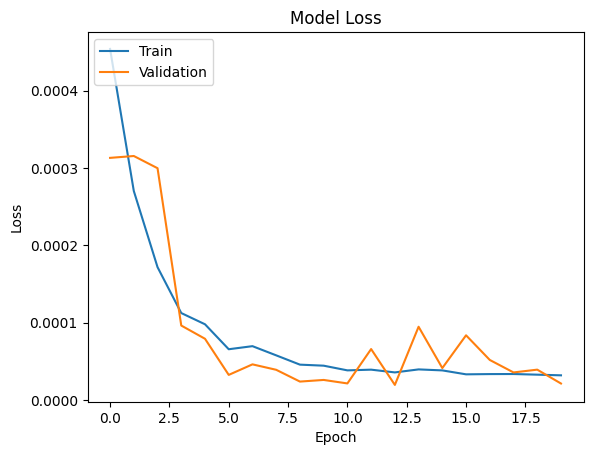

U-shaped graph saved at: unet_1.png


In [ ]:
unet = experiment.get_model()

unet.plot_loss()

unet.summary(graph=True, graph_name="unet_1")

In [ ]:
df = pd.read_csv(csv_path)
#df.head(len(df))
#df.describe()
df.iloc[-1]

Experiment number                             1
Name                                      MSE 1
Date                 2023-06-02 08:23:22.395190
Optimizer                                  Adam
Learning rate                             0.001
Loss                           MeanSquaredError
Input shape                       (128, 128, 3)
Output shape                      (128, 128, 1)
Filters                          [64, 128, 256]
Dropout                                     0.2
Epochs                                       20
Batch size                                    1
Test SSIM                              0.991549
Test PSNR                              46.74979
Test MSE                               0.000021
Name: 0, dtype: object

1/1 [==============================] - 0s 22ms/step


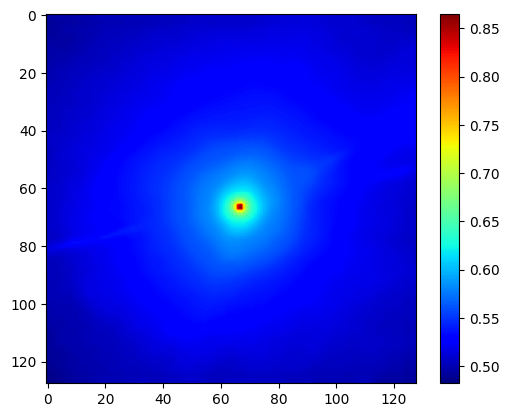

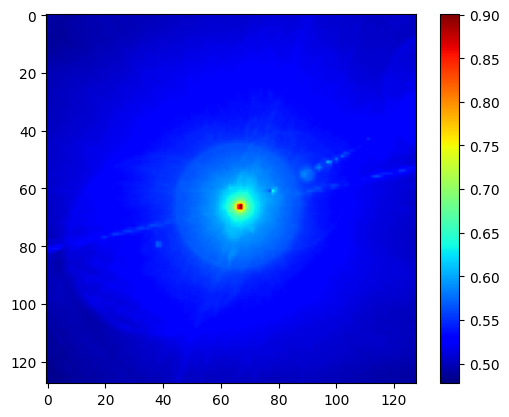

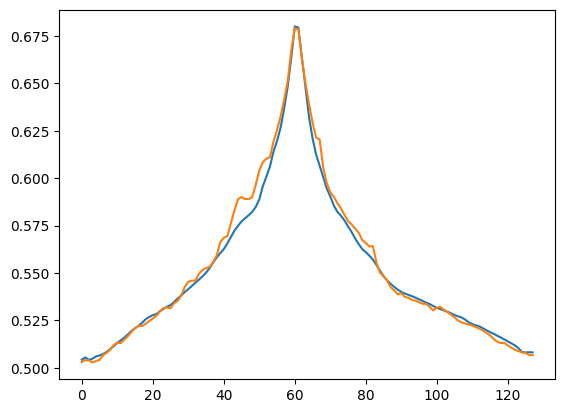

In [ ]:
ind = random.randint(0, X_test.shape[0]-1)
pred = unet.predict(X_test[ind:ind+1])
azimut = dataset.azimut_list[ind]
# plot the prediction, ground truth and radial profile of the prediction
plot_map(pred[0,:,:,0])
plot_map(y_test[ind])
plot_radial_profile([pred[0,:,:,0], y_test[ind]], azimut)
plt.show()